## Create custom Plots from your dataset
The intend of this markdown is to provide you with the tools you need to visualize your data by selecting in a custom fassion the plots you want to create and the relationships you want to visualize.

### Table of Contents
- [First Steps](#first-steps)
    - [Import your Data](#import-your-data) ⚠️
    - [Outlier detection](#outlier-detection)
- [Create Qualitative Plots](#create-qualitative-plots)
- [Create Quantitative Plots](#create-quantitative-plots)
    - [Create a Scatterplot Matrix to visualize the all realtionships in your data](#create-a-scatterplot-matrix-to-visualize-the-all-realtionships-in-your-data)
- [Plotly Interface](#plotly-interface)

# First Steps
### Import your Data

In [7]:
from matplotlib import image
import seaborn as sns
import pandas as pd
import rospkg
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [8]:
path = rospkg.RosPack().get_path('arena-evaluation') + '/02_evaluation'
data = pd.read_feather(path+'/data.ftr')
data['category'] = 'None'
data.loc[data.vel.notnull(),['category']] = 'var'
data.loc[data.path_length.notnull(),['category']] = 'med'

In [21]:
# select only relevant columns
data = data.loc[data.category == 'med',:]

### Outlier detection
Wrong values in your dataset can, if not detected, seriously impact the evaluation accuracy. 
There are a number of different ways to check your data for outliers. As these must be choosen on a case by case basis, we provide here only a helpful selection.

In [31]:
# data.describe()
data_quali = data.iloc[:,:18]

# Create Qualitative Plots
Qualitative plots visualize the paths, taken by the robot in the simulated world.

In [ ]:
def get_qualitative_plots(self):
    os.mkdir(self.plot_dir + "/qualitative_plots")
    ### iteration part ###
    for map in self.maps:
        map_keys = [] # list of keys with current map
        map_path = self.maps_dict[map]
        with open(map_path+"/map.yaml") as file: # get map file from map.yaml in map directory
            map_yaml = yaml.safe_load(file)
            map_file = map_yaml["image"]
            map_resolution = map_yaml["resolution"]
            map_origin = map_yaml["origin"]
        for key in self.keys:
            if self.data[key]["map"] == map:
                map_keys.append(key) # append key if map matches current map
        for velocity in self.velocities:
            vel_keys = [] # list of keys with current velocity
            for key in map_keys:
                if self.data[key]["velocity"] == velocity:
                    vel_keys.append(key) # append key if velocity matches current velocity
            for obstacle_number in self.obstacle_numbers:
                obs_keys = [] # list of keys with the current obstacle number
                for key in vel_keys:
                    if self.data[key]["obstacle_number"] == obstacle_number:
                        obs_keys.append(key) # append key if obstacle_number matches current obstacle_number

                if len(obs_keys) == 0:
                    continue

                ### plotting part ###
                fig, ax = plt.subplots()

                # plot map image
                img= image.imread("{0}/{1}".format(map_path,map_file))
                img_rotated = ndimage.rotate(img, 90, reshape=True) # rotate by 90 degree to get rviz konvention
                plt.imshow(img_rotated, cmap="gray")

                # plot each planners path and if flag given collisions and zones
                for key in sorted(obs_keys):
                    # plot paths for every episode
                    planner = self.data[key]["planner"]
                    if planner in self.config["leave_out_planner"]:
                        continue
                    paths = self.data[key]["paths_travelled"]
                    episodes = paths.keys()
                    for i,episode in enumerate(episodes):
                        if i == 0:
                            if "3d" in planner:
                                plt.plot([],[], # plot legend only with empty lines
                                "--",
                                label = self.config["labels"][planner],
                                alpha = self.config["path_3D_alpha"],
                                color = self.config["color_scheme"][planner],
                                linewidth = 2)
                            else:
                                plt.plot([],[], # plot legend only with empty lines
                                "-",
                                label = self.config["labels"][planner],
                                color = self.config["color_scheme"][planner],
                                linewidth = 2)                                    

                        x,y = to_ros_coords(paths[episode], img, map_resolution, map_origin)
                        x = x[3:-3] # NOTE: sometimes episode is wrongly assigned _> skip first and last coordinates
                        y = y[3:-3]
                        if "3d" in planner:
                            plt.plot(x,y,
                            "--",
                            color = self.config["color_scheme"][planner],
                            alpha = self.config["path_3D_alpha"],
                            linewidth = self.config["path_size"]/map_resolution,zorder=1)
                        else:
                            plt.plot(x,y,
                            "-",
                            color = self.config["color_scheme"][planner],
                            alpha = self.config["path_alpha"],
                            linewidth = self.config["path_size"]/map_resolution,zorder=1)

                        if self.config["plot_progression"]:
                            x_progression = x[0::self.config["plot_progression_steps"]]
                            y_progression = y[0::self.config["plot_progression_steps"]]
                            plt.scatter(x_progression,y_progression,
                            color = self.config["color_scheme"][planner],
                            alpha = self.config["path_alpha"],
                            s = self.config["plot_progression_size"]/map_resolution,zorder=1)

                    # plot collisions
                    if self.config["plot_collisions"]:
                        collisions = self.data[key]["collision_zones"]["collisions"]
                        if len(collisions) != 0:
                            x,y = to_ros_coords(collisions, img, map_resolution, map_origin)
                            plt.scatter(x,y,
                                color = self.config["color_scheme"][planner],
                                alpha = self.config["collision_alpha"],
                                s = self.config["collision_size"]/map_resolution,zorder=2)
                    # plot collision zones and centroids
                    if self.config["plot_collision_zones"]:
                        centroids = self.data[key]["collision_zones"]["centroids"]
                        if len(centroids) != 0:
                            counts = self.data[key]["collision_zones"]["counts"]
                            x,y = to_ros_coords(centroids, img, map_resolution, map_origin)
                            plt.scatter(x,y,
                                color = self.config["color_scheme"][planner],
                                alpha = self.config["collision_alpha"],
                                s = self.config["collision_size"]/map_resolution,zorder=2)
                            for i,centroid in enumerate(centroids):
                                # plot circle for collision zone
                                ax.add_patch(plt.Circle(tuple(to_ros_coords(centroid, img, map_resolution, map_origin)),
                                radius = self.config["collision_zone_base_diameter"]*counts[i]/map_resolution,
                                color=self.config["color_scheme"][planner],
                                fill=False,zorder=2))
                                # plot transparent circle as background of zone
                                ax.add_patch(plt.Circle(tuple(to_ros_coords(centroid, img, map_resolution, map_origin)),
                                radius = self.config["collision_zone_base_diameter"]*counts[i]/map_resolution,
                                color=self.config["color_scheme"][planner],
                                fill=True,
                                alpha = self.config["collision_zone_alpha"],zorder=2))

                # plot scenario properties (start, goal, dynamic obstacles)
                self.plot_scenario(obs_keys, img,  map_resolution, map_origin)

                # plot legend, title, axes labels
                if self.config["plot_qualitative_legend"]:
                    plt.legend(loc=self.config["plot_qualitative_legend_location"], fontsize=self.config["plot_qualitative_legend_fontsize"])
                else:
                    plt.legend(loc=self.config["plot_qualitative_legend_location"], fontsize=self.config["plot_qualitative_legend_fontsize"])
                    ax.get_legend().remove()
                if self.config["plot_qualitative_title"]:
                    if obstacle_number == "base_obstacle_number" and velocity == "base_velocity":
                        plt.title("Map: {0}".format(map), fontsize = self.config["plot_qualitative_title_size"], fontweight = "bold")
                    elif obstacle_number == "base_obstacle_number":
                        plt.title("Map: {0} Velocity: {1}.{2}".format(map, velocity.replace("vel","")[0], velocity.replace("vel","")[1]), fontsize = self.config["plot_qualitative_title_size"], fontweight = "bold")
                    elif velocity == "base_velocity":
                        plt.title("Map: {0}\n Obstacles: {1}".format(map, int(obstacle_number.replace("obs",""))), fontsize = self.config["plot_qualitative_title_size"], fontweight = "bold")
                    else:
                        plt.title("Map: {0}\n Obstacles: {1} Velocity: {1}.{2} ".format(map, int(obstacle_number.replace("obs","")), velocity.replace("vel","")[0], velocity.replace("vel","")[1]), fontsize = self.config["plot_qualitative_title_size"], fontweight = "bold")
                if self.config["plot_qualitative_axes"]:
                    plt.xlabel("x in [m]", fontsize=self.config["plot_qualitative_axes_size"])
                    plt.ylabel("y in [m]", fontsize=self.config["plot_qualitative_axes_size"])
                    x_locs = ax.get_xticks()[1:-1]
                    y_locs = ax.get_yticks()[1:-1]
                    ax.set_xticks(x_locs)
                    ax.set_xticklabels([int(x*map_resolution) for x in x_locs])
                    ax.set_yticks(y_locs)
                    ax.set_yticklabels([int(y*map_resolution) for y in y_locs])
                    ax.tick_params(axis='both', which='major', labelsize=self.config["plot_qualitative_axes_ticks_size"])
                else:
                    x_locs = ax.get_xticks()[1:-1]
                    y_locs = ax.get_yticks()[1:-1]
                    ax.set_xticks(x_locs)
                    ax.set_yticks(y_locs)
                    ax.set_xticklabels([])
                    ax.set_yticks(y_locs)
                    ax.set_yticklabels([])

                # plt.xlim(right=(100+100)/map_resolution)
                # plt.ylim(bottom=(100+100)/map_resolution)

                plt.savefig(self.plot_dir + "/qualitative_plots/qualitative_plot_{0}_{1}_{2}".format(map,obstacle_number,velocity), bbox_inches='tight',dpi=200)
                fig.clear(True)
                plt.close()

def plot_scenario(self, keys, img,  map_resolution, map_origin):
    scenario_dir = rospkg.RosPack().get_path('simulator_setup') + "/scenarios"
    scenario_dict = {x.split("/")[-1].replace(".json",""):x for x in sorted(glob.glob("{0}/*.json".format(scenario_dir)))}
    for scene in sorted(scenario_dict.keys()): # check if a map in /simulator_setup/maps fits scenario name
        if scene in keys[0]:
            scenario_path = scenario_dict[scene]
    with open(scenario_path) as file:
        scenario = json.load(file)
    if "pedsim_agents" in scenario.keys():
        dynamic_obstacles = scenario["pedsim_agents"]
        obstacle_paths = [[obstacle["pos"]]+ obstacle["waypoints"] for obstacle in dynamic_obstacles]
        start_x, start_y = to_ros_coords(scenario["robot_position"], img, map_resolution, map_origin)
        goal_x, goal_y = to_ros_coords(scenario["robot_goal"], img, map_resolution, map_origin)
        obstacle_paths = transform_waypoints(obstacle_paths, img, map_resolution, map_origin, ped_sim=True)
    else:
        start = scenario["scenarios"][0]["robot"]["start_pos"]
        goal = scenario["scenarios"][0]["robot"]["goal_pos"]
        dynamic_obstacles = scenario["scenarios"][0]["dynamic_obstacles"]
        obstacle_paths = [[dynamic_obstacles[obstacle]["start_pos"][:-1]]+[waypoint[:-1] for waypoint in dynamic_obstacles[obstacle]["waypoints"]] for obstacle in dynamic_obstacles]
        start_x, start_y = to_ros_coords(start, img, map_resolution, map_origin)
        goal_x, goal_y = to_ros_coords(goal, img, map_resolution, map_origin)
        obstacle_paths = transform_waypoints(obstacle_paths, img, map_resolution, map_origin)

    # plot start point and goal
    # labels for legend only
    plt.scatter([],[], marker = self.config["start_marker"], label = "Start", color = self.config["start_point_color"])
    plt.scatter([],[], marker = self.config["goal_marker"], label = "Goal", color = self.config["goal_point_color"])
    # start and goal point
    plt.scatter(start_x,start_y, marker = self.config["start_marker"], s = self.config["start_size"]/map_resolution, color = self.config["start_point_color"],zorder=5)
    plt.scatter(goal_x,goal_y, marker = self.config["goal_marker"], s = self.config["goal_size"]/map_resolution, facecolors = "none", edgecolors = self.config["goal_point_color"],zorder=5)

    # plot dynamic obstacle path
    for path in obstacle_paths:
        # plot waypoints as circles
        for i,waypoint in enumerate(path):
            plt.gca().add_patch(plt.Circle(waypoint,
                radius = self.config["obstacle_radius"]/map_resolution,
                color=self.config["obstacle_color"],
                fill=False,zorder=5))
            if i == len(path)-1:
                continue
            plt.gca().add_patch(patches.FancyArrowPatch(waypoint, path[i+1], arrowstyle='<->', mutation_scale = self.config["path_arrow_size"], color = self.config["path_arrow_color"],zorder=5))

# Create Quantitative Plots
Quantitative Plots quantify the performance of planner and robots etc. during the simulation runs. Jump to the section of the respective plot of interest.

### Create a Scatterplot Matrix to visualize the all realtionships in your data

In [ ]:
https://seaborn.pydata.org/examples/scatterplot_matrix.html

### Violine Plot

In [ ]:
https://seaborn.pydata.org/examples/wide_form_violinplot.html

In [ ]:
sns.jointplot(data=penguins, x="flipper_length_mm", y="bill_length_mm", hue="species")
https://seaborn.pydata.org/tutorial/function_overview.html#combining-multiple-views-on-the-data
https://seaborn.pydata.org/tutorial/categorical.html

In [11]:
# sample = data.loc[data.category == 'med', ['World', 'time', 'Robot']]
sample = data.loc[data.category == 'med', ['World', 'time', 'Robot','collision']]
# for element in ['World', 'time', 'Robot']:
# sns.violinplot(x=sample.Planner, y=sample.time)
# sample = sample[sample.time<179]


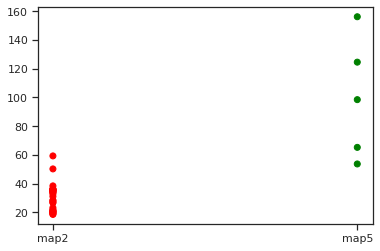

In [77]:
colors = {'jackal':'red','youbot':'green'}
plt.style.use('seaborn-dark-palette')
plt.scatter(x=sample['World'], y=sample['time'], c=sample['Robot'].map(colors));

In [54]:
robot = list(np.array(sample.Robot))
time = list(np.array(sample.time))
world = list(np.array(sample.World))

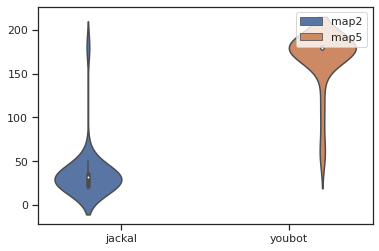

In [55]:
sns.violinplot(x=robot, y=time, hue=world);
plt.show()

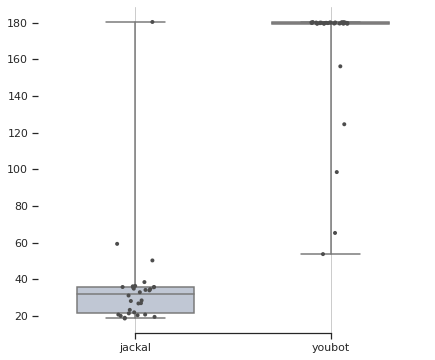

In [56]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Load the example planets dataset

# Plot the orbital period with horizontal boxes
sns.boxplot(x=robot, y=time, whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x=robot, y=time, size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

### 3D Plot

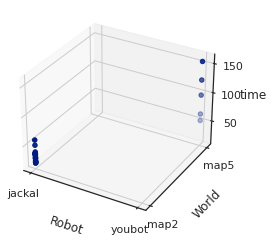

In [112]:
import matplotlib.pyplot as plt
import numpy as np

# variables
x = 'Robot'
y = 'World'
z = 'time'

plt.style.use('seaborn-dark-palette')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# xs = y=sample['Robot'].astype('category').cat.codes
# ys = sample['World'].astype('category').cat.codes
xs = pd.factorize(sample[x])[0]
ys = pd.factorize(sample[y])[0]
xs_0 = xs[0]
zs = sample[z]
ax.scatter(xs, ys, zs)

ax.axes.set_xticks(list(set(xs)))
ax.axes.set_xticklabels(sample[x].unique())
ax.axes.set_yticks(list(set(ys)))
ax.axes.set_yticklabels(sample[y].unique())

ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

plt.show()


# For colors: https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py

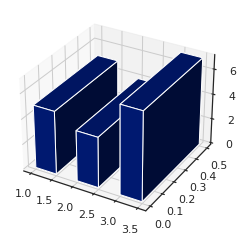

In [116]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x = [1, 2, 3]  # x coordinates of each bar
y = [0, 0, 0]  # y coordinates of each bar
z = [0, 0, 0]  # z coordinates of each bar
dx = [0.5, 0.5, 0.5]  # Width of each bar
dy = [0.5, 0.5, 0.5]  # Depth of each bar
dz = [5, 4, 7]        # Height of each bar

# Construct arrays with the dimensions for the 16 bars.

ax.bar3d(x, y, z, dx, dy, dz, zsort='average')


In [1]:
import plotly.express as px

In [2]:

df = px.data.iris()
fig = px.parallel_coordinates(df, color="species_id", labels={"species_id": "Species",
                  "sepal_width": "Sepal Width", "sepal_length": "Sepal Length",
                  "petal_width": "Petal Width", "petal_length": "Petal Length", },
                    color_continuous_scale=px.colors.diverging.Tealrose, color_continuous_midpoint=2)
fig.show()

In [12]:
# This makes only sense for numerical values
# https://pandas.pydata.org/docs/reference/api/pandas.plotting.parallel_coordinates.html
#pd.plotting.parallel_coordinates(sample, class_column='Robot',use_columns=True)

SyntaxError: invalid syntax (586349808.py, line 1)

In [ ]:
https://pandas.pydata.org/docs/reference/api/pandas.plotting.radviz.html


In [21]:
import plotly.express as px
df = px.data.tips()
#fig = px.parallel_categories(df, color="size", color_continuous_scale=px.colors.sequential.Inferno)
#fig.show()
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [29]:
sample['test'] = sample['time'].astype('int')
sample

,World,time,Robot,test
0,map2,20.787,jackal,20
1,map2,33.98,jackal,33
2,map2,35.817,jackal,35
3,map2,35.523,jackal,35
4,map2,34.648,jackal,34
5,map2,35.668,jackal,35
6,map2,28.179,jackal,28
8,map2,34.225,jackal,34
9,map2,26.847,jackal,26
10,map2,20.054,jackal,20


In [35]:
import plotly.express as px
df = px.data.tips()
fig = px.parallel_categories(sample.drop('time',1), color="test", color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

/tmp/ipykernel_3859622/986692669.py:3: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [52]:
import plotly.express as px
# print(sample)
# fig = px.parallel_categories(sample.drop('time',1), color="test", color_continuous_scale=px.colors.sequential.Inferno)
fig = px.scatter_3d(sample, x='World', y='Robot', z='time',
              color='collision')

fig.show()

# Plotly Interface

In [1]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px


In [ ]:
app = Dash(__name__)

app.layout = html.Div([
    html.H4('Iris samples filtered by petal width'),
    dcc.Graph(id="graph"),
    html.P("Petal Width:"),
    dcc.RangeSlider(
        id='range-slider',
        min=0, max=2.5, step=0.1,
        marks={0: '0', 2.5: '2.5'},
        value=[0.5, 2]
    ),
])

@app.callback(
    Output("graph", "figure"), 
    Input("range-slider", "value"))
def update_bar_chart(slider_range):
    df = px.data.iris() # replace with your own data source
    low, high = slider_range
    mask = (df.petal_width > low) & (df.petal_width < high)

    fig = px.scatter_3d(df[mask], 
        x='sepal_length', y='sepal_width', z='petal_width',
        color="species", hover_data=['petal_width'])
    return fig

app.run_server(debug=True)

In [33]:
from pandasgui import show

In [36]:
data_quali = data_quali.astype("category")

In [44]:

show(data_quali.iloc[:,1:])

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


/home/elias/python_env/rosnav/lib/python3.8/site-packages/ipykernel/eventloops.py:105: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.

/home/elias/python_env/rosnav/lib/python3.8/site-packages/ipykernel/eventloops.py:105: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.

/home/elias/python_env/rosnav/lib/python3.8/site-packages/ipykernel/eventloops.py:105: FutureWarning:

Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.

/home/elias/python_env/rosnav/lib/python3.8/site-packages/ipykernel/eventloops.py:105: FutureWarning